- It's easier to read using Colab, since it collapses the cells into different sections
- it mount the google drive for retreiving the data

# Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:
!pip install transformers
!pip install ktrain

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
     command: 'C:\Users\alex0\anaconda3\python.exe' -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\alex0\\AppData\\Local\\Temp\\pip-install-70y2t_md\\seqeval\\setup.py'"'"'; __file__='"'"'C:\\Users\\alex0\\AppData\\Local\\Temp\\pip-install-70y2t_md\\seqeval\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base 'C:\Users\alex0\AppData\Local\Temp\pip-pip-egg-info-i0x8trwv'
  Using cached fastprogress-1.0.0-py3-none-any.whl (12 kB)
  Using cached jieba-0.42.1.tar.gz (19.2 MB)
  Using cac

In [ ]:
# customed package for exploring and cleaning the tweet data
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall
import preprocess_kgptalkie as kgp

  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to /tmp/pip-req-build-i00pfpw_
  Running command git clone -q https://github.com/laxmimerit/preprocess_kgptalkie.git /tmp/pip-req-build-i00pfpw_
  Created wheel for preprocess-kgptalkie: filename=preprocess_kgptalkie-0.1.3-cp37-none-any.whl size=11743 sha256=f84110bf554e1e68f27be31b9514a86d512669eb0a630a7090a39d3d1a0cc5f1
  Stored in directory: /tmp/pip-ephem-wheel-cache-l2njc3vk/wheels/a8/18/22/90afa4bd43247fb9a75b710a4a3fcd94966c022ce9e3c7d0a6
Successfully built preprocess-kgptalkie


In [ ]:
import numpy as np
import pandas as pd
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')
import json

import ktrain
from ktrain import text

In [ ]:
import seaborn as sns
import re
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [3,2]
plt.rcParams['figure.dpi'] = 120
pd.set_option('display.max_colwidth', None)

In [ ]:
def load_sentence(file):
    with open(file) as f:
        df = pd.DataFrame(json.loads(line)[0] for line in f)
    return df

def load_label(file):
    with open(file) as f:
        data = json.load(f)
        df_label = pd.DataFrame(list(data.items()),columns=['id_str','rumor_or_not'])
    return df_label

In [ ]:
# loading training data
df_train = load_sentence('gdrive/MyDrive/NLP-project1/train.data.jsonl')
df_label = load_label('gdrive/MyDrive/NLP-project1/train.label.json')
df_full_train = pd.merge(df_train,df_label,on=['id_str'])

# expected to analyze the text and if it's the rumor
df_train_data = df_full_train[['text','rumor_or_not']]
labels = df_train_data['rumor_or_not']

In [ ]:
# loading validation data
df_dev = load_sentence('gdrive/MyDrive/NLP-project1/dev.data.jsonl')
df_label_dev = load_label('gdrive/MyDrive/NLP-project1/dev.label.json')

df_full_dev = pd.merge(df_dev,df_label_dev,on=['id_str'])
df_dev_data = df_full_dev[['text','rumor_or_not']]

labels_dev = df_dev_data['rumor_or_not']

In [ ]:
df_test = load_sentence('gdrive/MyDrive/NLP-project1/test.data.jsonl')
df_test_data = df_test[['text']]

In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
df_train_data['text'].head()

0          How to respond to the murderous attack on Charlie Hebdo? Every newspaper in the free world should print this. http://t.co/sC2ot63F6j
1            You can't condemn an entire race, nation or religion based on the actions of a few radicals, please keep that in mind #sydneysiege
2    Attempts to extend blame for this to all Muslims should be treated with the same disgust as attempts to justify the attacks. #CharlieHebdo
3                            Rest in Peace, Cpl. Nathan Cirillo. Killed today in #OttawaShooting\nhttp://t.co/YzLXYX5JJt http://t.co/8F0qAcj9sg
4     People DEBATING whether #MikeBrown shoplifted or not-- IT DOESN'T MATTER.\nShoplifting isn't punishable by DEATH IN THE STREET. #Ferguson
Name: text, dtype: object

# Basic data exploration before text preprocessing




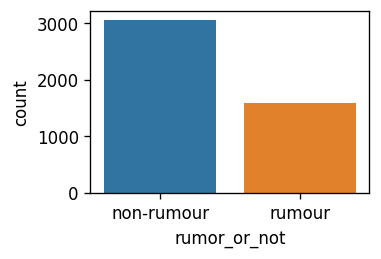

In [ ]:
# target class distribution
sns.countplot('rumor_or_not',data=df_train_data)

In [ ]:
df_train_data['rumor_or_not'].value_counts()

non-rumour    3058
rumour        1583
Name: rumor_or_not, dtype: int64

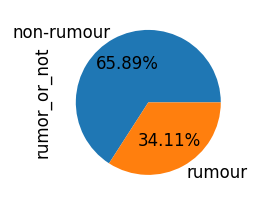

In [ ]:
df_train_data['rumor_or_not'].value_counts().plot.pie(autopct='%1.2f%%')

In [ ]:
# original data from df_train_data['text']
tweet = kgp.get_basic_features(df_train_data)

In [ ]:
tweet.head(1)

,text,rumor_or_not,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts
0,<CLS> How to respond to the murderous attack on Charlie Hebdo <SEP> Every newspaper in the free world should print this <SEP> HTTPURL <SEP>,non-rumour,116,24,4.833333,8,0,0,0,5


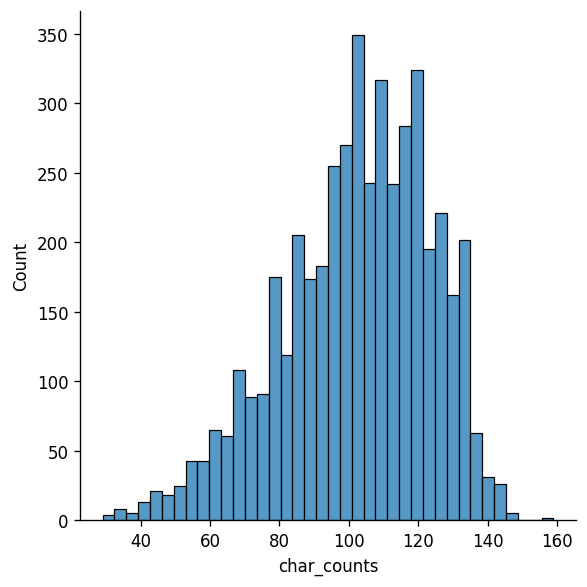

In [ ]:
sns.displot(tweet['char_counts'])

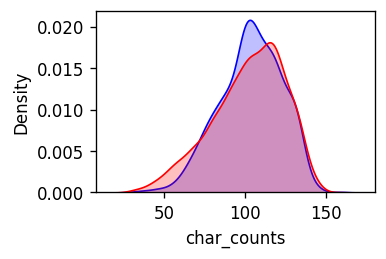

In [ ]:
# it seems the rumour information would be generally less density than non-rumour tweet -> what does it imply??
sns.kdeplot(tweet[tweet['rumor_or_not']=='rumour']['char_counts'],shade=True,color='blue') # bule one
sns.kdeplot(tweet[tweet['rumor_or_not']=='non-rumour']['char_counts'],shade=True,color='red') # orange one

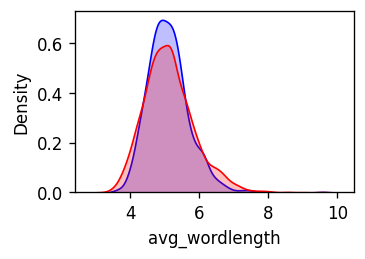

In [ ]:
sns.kdeplot(tweet[tweet['rumor_or_not']=='rumour']['avg_wordlength'],shade=True,color='blue') # bule one
sns.kdeplot(tweet[tweet['rumor_or_not']=='non-rumour']['avg_wordlength'],shade=True,color='red') # orange one

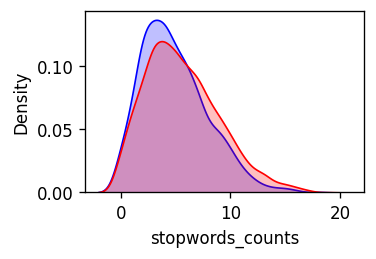

In [ ]:
# rumour has more stopwords -> deliver less information
sns.kdeplot(tweet[tweet['rumor_or_not']=='rumour']['stopwords_counts'],shade=True,color='blue')
sns.kdeplot(tweet[tweet['rumor_or_not']=='non-rumour']['stopwords_counts'],shade=True,color='red')

In [ ]:
freqs = kgp.get_word_freqs(tweet, 'text')

In [ ]:
top20 = freqs[:20]

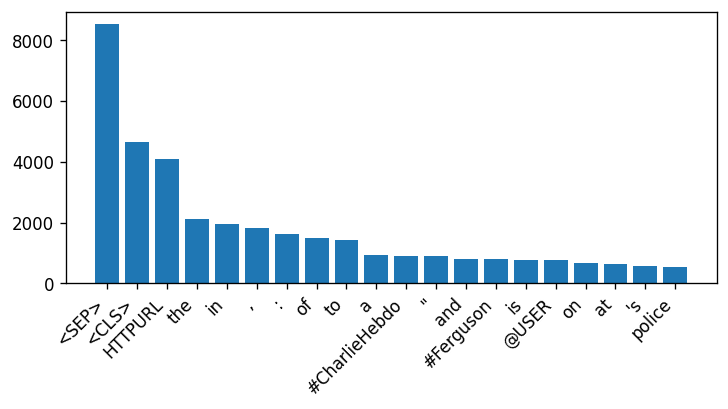

In [ ]:
plt.figure(figsize=(7,3))
plt.bar(top20.index, top20.values)
# https://stackoverflow.com/questions/10998621/rotate-axis-text-in-python-matplotlib
plt.xticks(rotation=45,ha='right')
plt.show()

In [ ]:
least20 = freqs[-20:]
least20

Safe            1
collection      1
Taking          1
Murdered        1
Knowles         1
perimeter       1
FRENCH          1
commemorates    1
gutless         1
menacing        1
#Shame          1
Mhm             1
ghostly         1
cliffs          1
fields          1
boycott         1
whats           1
Gogh            1
notoriously     1
#GERMANWINGS    1
dtype: int64

In [ ]:
bigram = kgp.get_ngram(tweet, 'text', ngram_range=2)

In [ ]:
bigram[:20]

[('호르몬전쟁 hello_hello', 35958),
 ('últimahora es', 35957),
 ('zuckerberg on', 35956),
 ('zones sep', 35955),
 ('zones can', 35954),
 ('zone will', 35953),
 ('zone to', 35952),
 ('zone that', 35951),
 ('zone sep', 35950),
 ('zone remains', 35949),
 ('zone please', 35948),
 ('zone in', 35947),
 ('zone httpurl', 35946),
 ('zone around', 35945),
 ('zimmerman was', 35944),
 ('zero repeat', 35943),
 ('zero pilots', 35942),
 ('zero coverage', 35941),
 ('zeid httpurl', 35940),
 ('zehaf bibeau', 35939)]

# Data Cleaning

In [ ]:
# should replace it with a token to keep the features
def get_data_without_urls(text):
    return re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘]))''', "HTTPURL", text)

In [ ]:
def normalize_user(x):
  x = str(x)
  for token in x.split():
    if token.startswith('@') or token.startswith('"@'):
        x = x.replace(token,'@USER')
  return x
def remove_symbol(x):
  x = str(x)
  filtered_list = []
  for token in x.split():
    filtered_list.append(token.replace("\n","").replace("#","").replace('"'," ").replace("*",'').replace("&amp","").replace("&gt","").replace("'","").replace("w/",""))
  x = filtered_list
  x = ' '.join(x)
  return x

In [ ]:
def get_clean(x):
    x = str(x).lower().replace('\\', '').replace('_', ' ').replace('-', ' ').replace(':', ' ').replace(',', ' ').replace(';',"").replace('&amp',"").replace('→', " ").replace('...',' ').replace("|", " ").replace("‘","").replace('.', ' ').replace('!', ' ').replace('?', ' ')
    x = kgp.cont_exp(x) #you're -> you are; i'm -> i am
    x = kgp.remove_emails(x)
    x = normalize_user(x)
    x = remove_symbol(x)
    x = kgp.remove_rt(x)
    x = kgp.remove_accented_chars(x)
    x = re.sub("(.)\\1{2,}", "\\1", x) # 'lllooooovvveeee youuuu' -> I love you
    return x

In [ ]:
# replace url with httpurl, replace tagging to user
df_train_data['text'] = df_train_data['text'].apply(get_data_without_urls)
df_train_data['text'] = df_train_data['text'].apply(lambda x: get_clean(x))

In [ ]:
# clean up the other things such as hashtags and other symbols such as "\n"
df_dev_data['text'] = df_dev_data['text'].apply(get_data_without_urls)
df_dev_data['text'] = df_dev_data['text'].apply(lambda x: get_clean(x))

df_test['text'] = df_test['text'].apply(get_data_without_urls)
df_test['text'] = df_test['text'].apply(lambda x: get_clean(x))

In [ ]:
df_train_data['text'].head(30)

0                           how to respond to the murderous attack on charlie hebdo every newspaper in the free world should print this httpurl
1              you cannot condemn an entire race nation or religion based on the actions of a few radicals please keep that in mind sydneysiege
2      attempts to extend blame for this to all muslims should be treated with the same disgust as attempts to justify the attacks charliehebdo
3                                                               rest in peace cpl nathan cirillo killed today in ottawashooting httpurl httpurl
4          people debating whether mikebrown shoplifted or not it does not matter shoplifting is not punishable by death in the street ferguson
5                                                                            update pa gunman holding hostages in paris grocery has been killed
6                                       heres a recap of the key points so far in the germanwings alps plane crash live updates httpurl 

# Data exploration after data cleaning

In [ ]:
tweet = kgp.get_basic_features(df_train_data)

In [ ]:
bigram = kgp.get_ngram(tweet, 'text', ngram_range=2)

In [ ]:
bigram[:20]

[('zuckerberg on', 34971),
 ('zones think', 34970),
 ('zones can', 34969),
 ('zone will', 34968),
 ('zone to', 34967),
 ('zone that', 34966),
 ('zone remains', 34965),
 ('zone please', 34964),
 ('zone in', 34963),
 ('zone httpurl', 34962),
 ('zone around', 34961),
 ('zone al', 34960),
 ('zimmerman was', 34959),
 ('zero repeat', 34958),
 ('zero pilots', 34957),
 ('zero coverage', 34956),
 ('zeid httpurl', 34955),
 ('zehaf bibeau', 34954),
 ('zehaf bebeau', 34953),
 ('zayn malik', 34952)]

In [ ]:
rumor = kgp.get_word_freqs(tweet[tweet['rumor_or_not']=='rumour'],'text')
rumor = ' '.join(rumor.index)
rumor

'httpurl in the of to a police at breaking sydney on is and ferguson ottawa @USER sydneysiege hostages paris cafe hostage shooting was charliehebdo germanwings shot are parliament has as have with for that not french from soldier reports killed gunman says attack been people dead by after update memorial war news this hill one now suspects flag live say it gunmen an be charlie who ottawashooting hebdo two 2 suspect canadian held out siege more mikebrown were he officer michael man pilot shots crashed robbery &amp; inside they plane being least there up situation france brown lindt a320 nathan fired cirillo media taken chief airbus minister co report near video 4u9525 just confirm 3 i you kosher before isis flight confirmed islamic if today latest down shootings muslim armed prime no his all but name place we still him about did shooter where crash centre injured national cpl 9news their so pd afp 1 convert taker via building canada three martin store alps satirical why reportedly germa

In [ ]:
from wordcloud import WordCloud

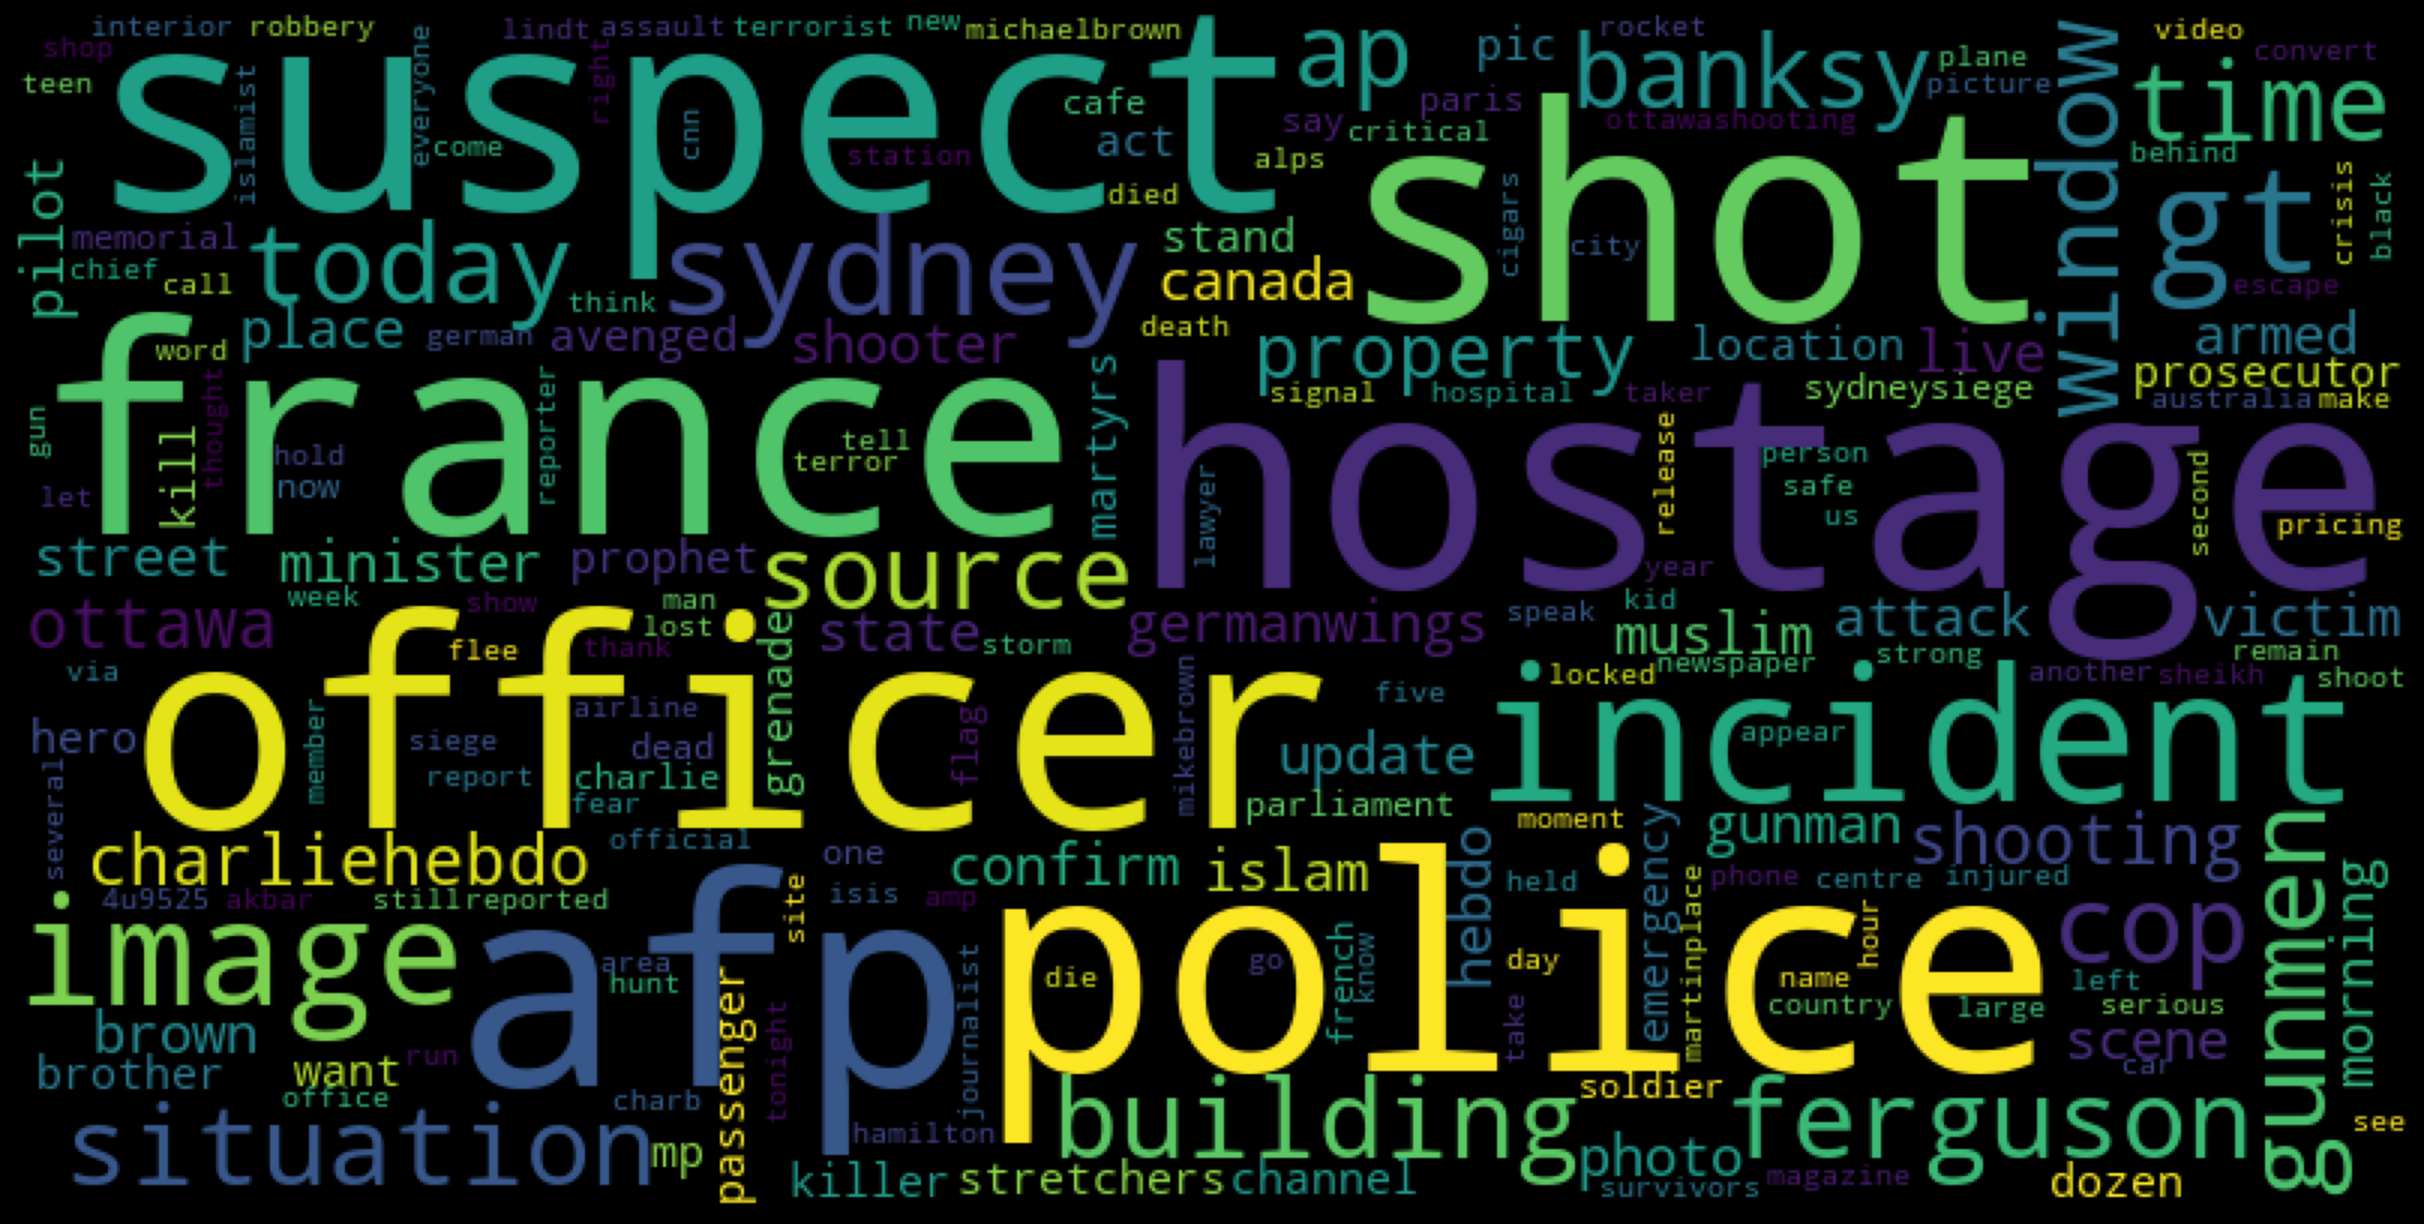

In [ ]:
word_cloud = WordCloud(max_font_size=100,width=800, height=400).generate(rumor)
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(word_cloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [ ]:
non_rumor = kgp.get_word_freqs(tweet[tweet['rumor_or_not']=='non-rumour'],'text')
non_rumor = ' '.join(non_rumor.index)
non_rumor

'httpurl the in to of charliehebdo is a ferguson and @USER on not for police are at with sydneysiege this attack jesuischarlie you we charlie from sydney paris it hebdo i ottawa by have people be as &amp; that all shooting our will do if has germanwings what about now " was french my their they out mikebrown france after who muslim no thoughts hostage but us up retweet just muslims live today media hostages right an those killed more breaking or one say so than how illridewithyou your says victims crash solidarity know can he been world black situation cartoons prayers would cartoon over news 4u9525 terrorist islam freedom please his everyone cafe man support ottawashooting free stand there where why terror like speech being siege stay am suspects photo cops should safe when me them here video let new parliament flight these attacks religion 2 families scene time terrorists via gunman cartoonists against day only before chief shot white go its photos parisshooting again magazine need t

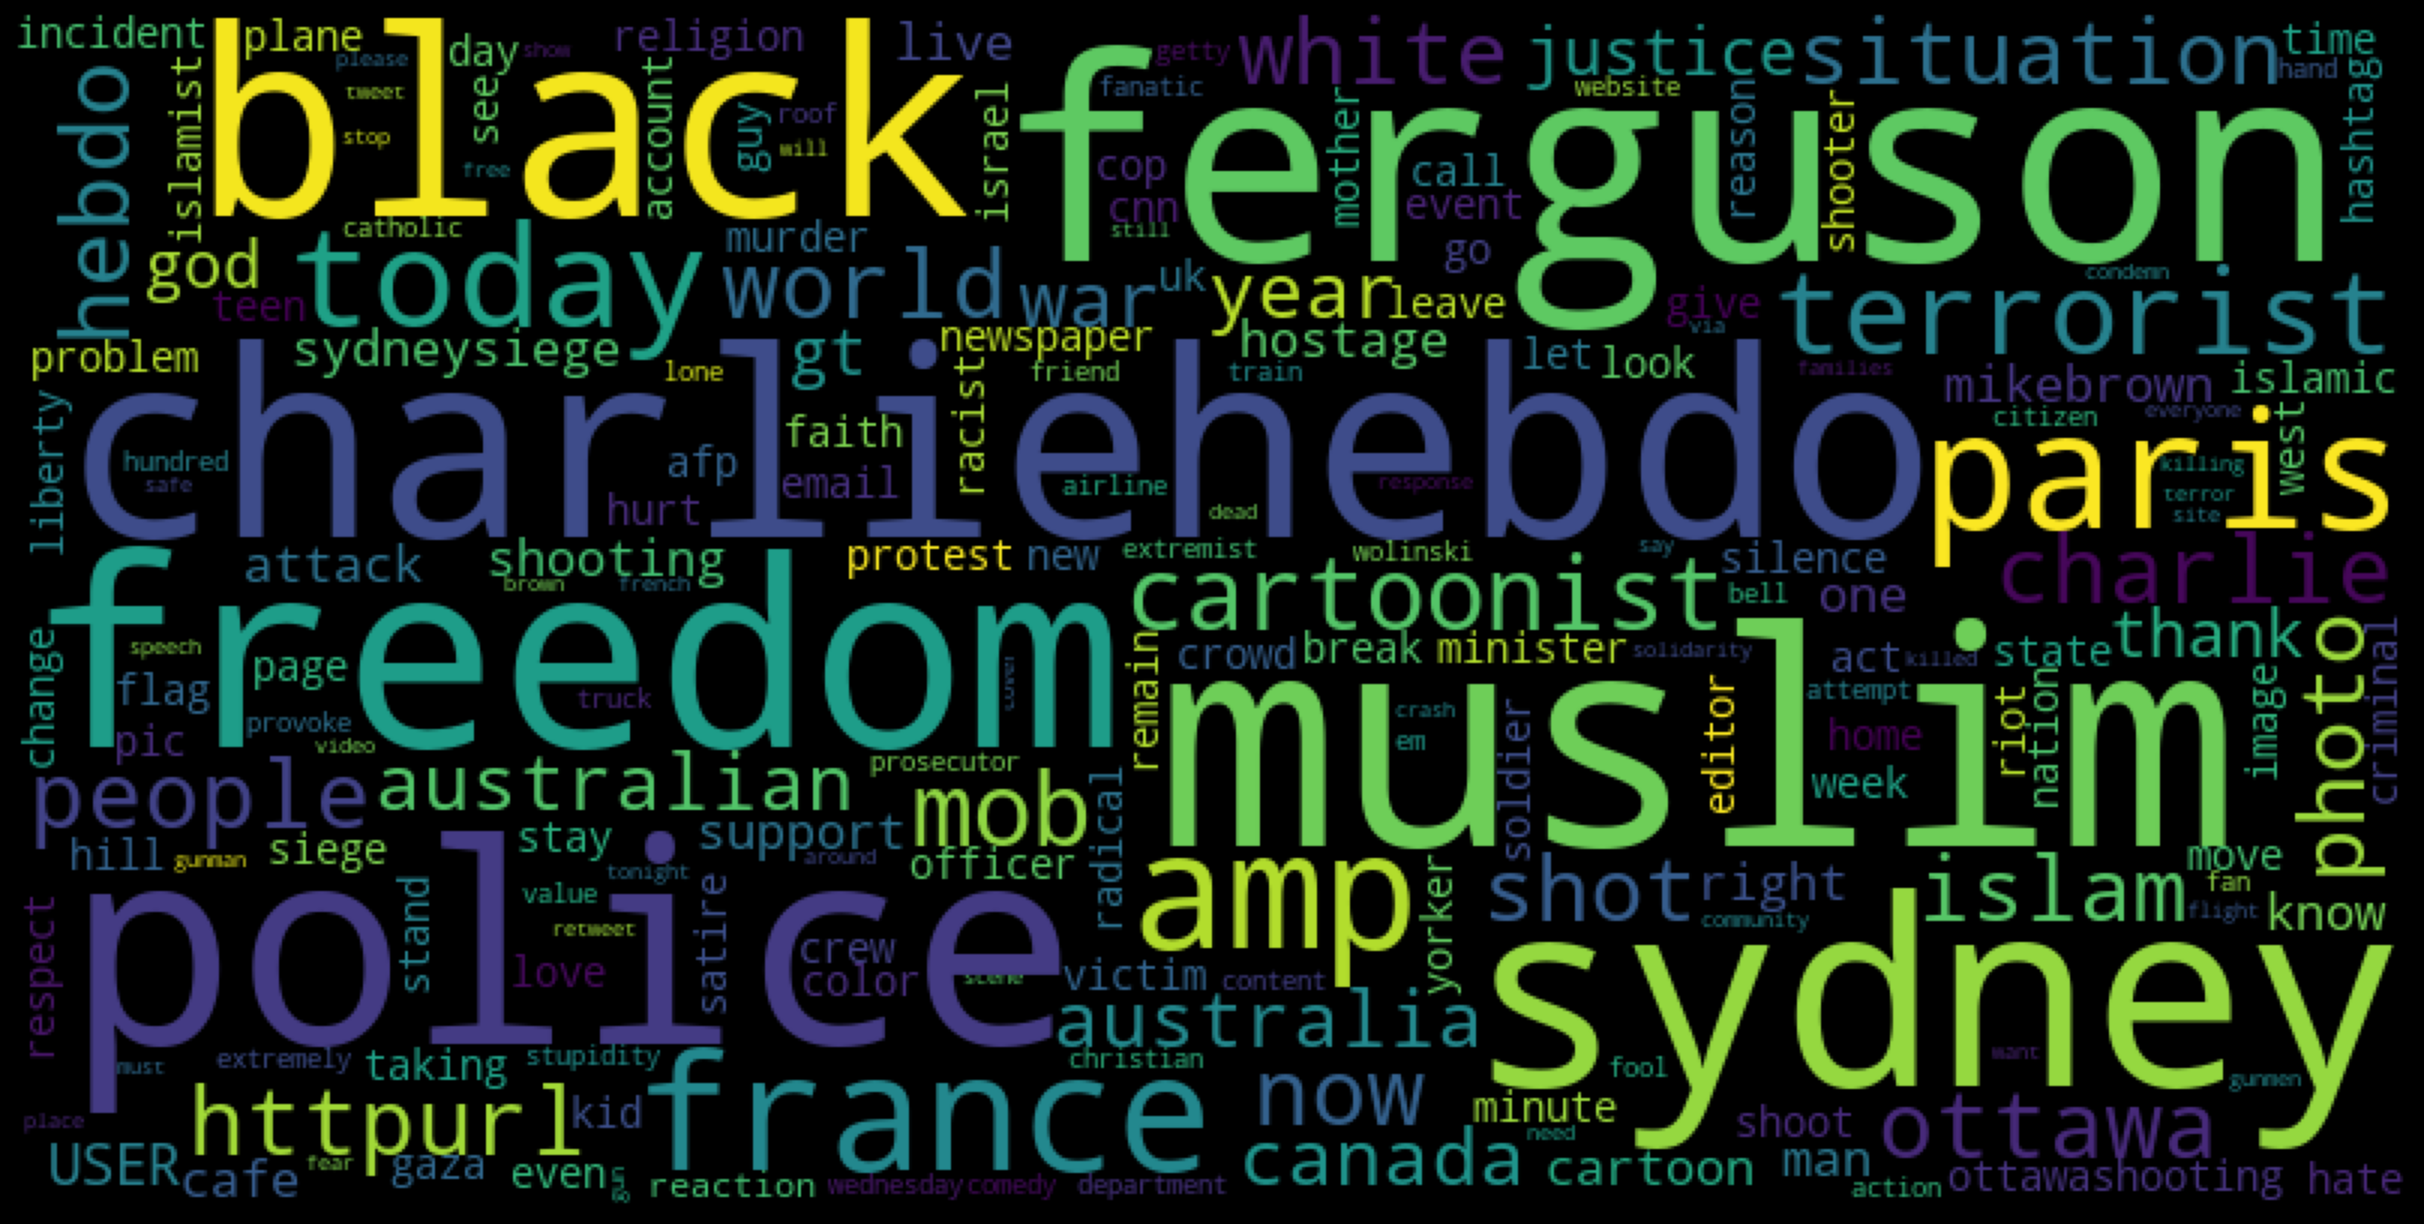

In [ ]:
word_cloud = WordCloud(max_font_size=100,width=800, height=400).generate(non_rumor)
plt.figure(figsize=(20,10), facecolor='k')
plt.imshow(word_cloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

# Methods dealing with data imbalance

## Class weight adjustment, re-check the data

In [ ]:
from sklearn.utils import compute_class_weight
# https://imbalanced-learn.org/stable/auto_examples/applications/plot_impact_imbalanced_classes.html
class_weight = compute_class_weight('balanced',np.unique(df_train_data['rumor_or_not']),df_train_data['rumor_or_not'])
class_weight = dict(enumerate(class_weight))

In [ ]:
print(class_weight)

{0: 0.7588293001962066, 1: 1.4658875552747948}


In [ ]:
# print out and see if anything needs to be dealt with
df_train_data['text'].head()

0                         how to respond to the murderous attack on charlie hebdo every newspaper in the free world should print this httpurl
1            you cannot condemn an entire race nation or religion based on the actions of a few radicals please keep that in mind sydneysiege
2    attempts to extend blame for this to all muslims should be treated with the same disgust as attempts to justify the attacks charliehebdo
3                                                             rest in peace cpl nathan cirillo killed today in ottawashooting httpurl httpurl
4        people debating whether mikebrown shoplifted or not it does not matter shoplifting is not punishable by death in the street ferguson
Name: text, dtype: object

In [ ]:
df_dev_data['text'].head()

0                                                breaking reports 2 brothers suspected of charlie hebdo attack are dead httpurl
1                          you are not alone today ottawa we are here if you need to talk cry whatever we are here 613 238 3311
2    have said it before but needs saying again stop asking muslims to condemn terrorism it is bigoted and islamophobic httpurl
3                                germanwings a320 plane crashes in southern france french prime minister says more soon httpurl
4                  hostage situation in sydney to all our fans and friends staying in sydney stay safe and keep praying httpurl
Name: text, dtype: object

## Over-sampling and under-sampling
- could try, but the performance degrade overall

In [ ]:
from sklearn.utils import resample

In [ ]:
df_majority = df_train_data.loc[df_train_data.rumor_or_not == 'non-rumour'].copy()
df_minority = df_train_data.loc[df_train_data.rumor_or_not == 'rumour'].copy()

df_majority_downsampled = resample(df_majority,
                   replace=False,
                   n_samples=2800)

df_minority_upsampled = resample(df_minority,
                  replace=True,
                  n_samples=2000)

df_balanced = pd.concat([df_majority_downsampled, df_minority_upsampled])
print(df_balanced.rumor_or_not.value_counts())

non-rumour    2500
rumour        2000
Name: rumor_or_not, dtype: int64


In [ ]:
df_majority = df_train_data.loc[df_train_data.rumor_or_not == 'non-rumour'].copy()
df_minority = df_train_data.loc[df_train_data.rumor_or_not == 'rumour'].copy()

df_minority_upsampled = resample(df_minority,
                  replace=True,
                  n_samples=2000)
df_oversampled = pd.concat([df_majority, df_minority_upsampled])
print(df_oversampled.rumor_or_not.value_counts())

non-rumour    3058
rumour        2000
Name: rumor_or_not, dtype: int64


## Text augmentation
- could try, but it seems not helpful in this case

In [ ]:
# applied to augment the text
!pip install numpy git+https://github.com/makcedward/nlpaug.git

  Cloning https://github.com/makcedward/nlpaug.git to /tmp/pip-req-build-_8p9b2qw
  Running command git clone -q https://github.com/makcedward/nlpaug.git /tmp/pip-req-build-_8p9b2qw
  Created wheel for nlpaug: filename=nlpaug-1.1.3-cp37-none-any.whl size=837272 sha256=0d2030549a7b4df906ce8182fa660ac3f9f5502c757b6f84e735246dd54d2474
  Stored in directory: /tmp/pip-ephem-wheel-cache-ewc9ds21/wheels/2b/ef/30/a4e22f9a97373c9ab6763670c94aa5e111b0b956983f3892a4
Successfully built nlpaug


In [ ]:
# https://github.com/makcedward/nlpaug/blob/master/example/textual_augmenter.ipynb
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas

In [ ]:
# augment the rumour part of information for model training
aug = naw.ContextualWordEmbsAug(
    model_path='distilbert-base-uncased', action="substitute")

In [ ]:
def augmented(x):
  x = str(x)
  augment = aug.augment(x)
  return augment

In [ ]:
# df_train_data['text'] = df_train_data['text'].apply(augmented)

In [ ]:
df_train_data.head()

,text,rumor_or_not
0,how to respond without any terrorist attack... charlie hebdo every newspaper in the free zone should print a propaganda,non-rumour
1,you should condemn an organized race nation or religion based up the actions within a few radicals who keep us in your sydneysiege,non-rumour
2,attempts for extend blame for this murdering tunisian muslims may be viewed with the same disgust as it can justify the attacks charliehebdo,non-rumour
3,rest see bold candidate nathan cirillo rodriguez whilst in ottawashooting httpurl smith,rumour
4,supporters ask whether mikebrown shoplifted or while selling does would matter either is not punishable by driving in the street anymore,non-rumour


# BERT model building

In [ ]:
(X_train, y_train), (X_test, y_test), preproc = text.texts_from_df(train_df=df_train_data,
                                    text_column='text',
                                    label_columns='rumor_or_not',
                                    val_df=df_dev_data,
                                    maxlen=200,
                                    preprocess_mode='bert')

['non-rumour', 'rumour']
   non-rumour  rumour
0         1.0     0.0
1         1.0     0.0
2         1.0     0.0
3         0.0     1.0
4         1.0     0.0
['non-rumour', 'rumour']
   non-rumour  rumour
0         0.0     1.0
1         1.0     0.0
2         1.0     0.0
3         0.0     1.0
4         0.0     1.0
downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


In [ ]:
model = text.text_classifier(name='bert', train_data=(X_train, y_train), preproc=preproc)

Is Multi-Label? False
maxlen is 200
done.


In [ ]:
learner = ktrain.get_learner(model=model, train_data=(X_train, y_train), val_data=(X_test, y_test), batch_size=2)

In [ ]:
learner.fit_onecycle(2e-5,2,class_weight=class_weight)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/2
2321/2321 [==============================] - 2542s 1s/step - loss: 0.5507 - accuracy: 0.7130 - val_loss: 0.3207 - val_accuracy: 0.8448
Epoch 2/2
2321/2321 [==============================] - 2532s 1s/step - loss: 0.2986 - accuracy: 0.8710 - val_loss: 0.2828 - val_accuracy: 0.8690


In [ ]:
learner.validate(class_names=preproc.get_classes())

              precision    recall  f1-score   support

  non-rumour       0.93      0.87      0.90       393
      rumour       0.76      0.87      0.81       187

    accuracy                           0.87       580
   macro avg       0.85      0.87      0.86       580
weighted avg       0.88      0.87      0.87       580



array([[341,  52],
       [ 24, 163]])

In [ ]:
# equal class weight, batches=2, epoch=2
# clean up all the hashtags, urls, and users tags
# precision    recall  f1-score   support

#   non-rumour       0.93      0.89      0.91       393
#     rumour       0.79      0.86      0.82       187

#accuracy                           0.88       580
#   macro avg       0.86      0.87      0.87       580
# weighted avg       0.88      0.88      0.88       580

# array([[351,  42],
#    [ 27, 160]])

In [ ]:
# predictor = ktrain.get_predictor(learner.model, preproc)

In [ ]:
# predictor.save('content/gdrive/bert1')

# DistilBERT

In [ ]:
df_train_data['text'].head()

0                         how to respond to the murderous attack on charlie hebdo every newspaper in the free world should print this httpurl
1            you cannot condemn an entire race nation or religion based on the actions of a few radicals please keep that in mind sydneysiege
2    attempts to extend blame for this to all muslims should be treated with the same disgust as attempts to justify the attacks charliehebdo
3                                                             rest in peace cpl nathan cirillo killed today in ottawashooting httpurl httpurl
4        people debating whether mikebrown shoplifted or not it does not matter shoplifting is not punishable by death in the street ferguson
Name: text, dtype: object

In [ ]:
# wanted to add the <CLS>, <SEP> manually, but the model doesn't improve

# df_train_data['text'] = df_train_data['text'].apply(lambda x : add_special_token(x))
# df_train_data['text'] = df_train_data['text'].apply(lambda x : sentence_end_special_token(x))
# df_train_data['text'] = df_train_data['text'].apply(lambda x : remove_consective_SEP(x))

# df_dev_data['text'] = df_dev_data['text'].apply(lambda x : add_special_token(x))
# df_dev_data['text'] = df_dev_data['text'].apply(lambda x : sentence_end_special_token(x))
# df_dev_data['text'] = df_dev_data['text'].apply(lambda x : remove_consective_SEP(x))

# df_test['text'] = df_test['text'].apply(lambda x : add_special_token(x))
# df_test['text'] = df_test['text'].apply(lambda x : sentence_end_special_token(x))
# df_test['text'] = df_test['text'].apply(lambda x : remove_consective_SEP(x))

In [ ]:
df_train_data['text'].head()

0                         how to respond to the murderous attack on charlie hebdo every newspaper in the free world should print this httpurl
1            you cannot condemn an entire race nation or religion based on the actions of a few radicals please keep that in mind sydneysiege
2    attempts to extend blame for this to all muslims should be treated with the same disgust as attempts to justify the attacks charliehebdo
3                                                             rest in peace cpl nathan cirillo killed today in ottawashooting httpurl httpurl
4        people debating whether mikebrown shoplifted or not it does not matter shoplifting is not punishable by death in the street ferguson
Name: text, dtype: object

In [ ]:
text.print_text_classifiers()

fasttext: a fastText-like model [http://arxiv.org/pdf/1607.01759.pdf]
logreg: logistic regression using a trainable Embedding layer
nbsvm: NBSVM model [http://www.aclweb.org/anthology/P12-2018]
bigru: Bidirectional GRU with pretrained fasttext word vectors [https://fasttext.cc/docs/en/crawl-vectors.html]
standard_gru: simple 2-layer GRU with randomly initialized embeddings
bert: Bidirectional Encoder Representations from Transformers (BERT) from keras_bert [https://arxiv.org/abs/1810.04805]
distilbert: distilled, smaller, and faster BERT from Hugging Face transformers [https://arxiv.org/abs/1910.01108]


In [ ]:
train, val, preproc = text.texts_from_df(train_df=df_train_data,
                       text_column='text',
                       label_columns='rumor_or_not',
                       val_df=df_dev_data,
                       maxlen=170,
                       preprocess_mode='distilbert',
                       lang='en')

['non-rumour', 'rumour']
   non-rumour  rumour
0         1.0     0.0
1         1.0     0.0
2         1.0     0.0
3         0.0     1.0
4         1.0     0.0
['non-rumour', 'rumour']
   non-rumour  rumour
0         0.0     1.0
1         1.0     0.0
2         1.0     0.0
3         0.0     1.0
4         0.0     1.0
preprocessing train...
language: en
train sequence lengths:
	mean : 16
	95percentile : 24
	99percentile : 26


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 16
	95percentile : 24
	99percentile : 26


In [ ]:
model = text.text_classifier(name='distilbert', train_data=train, preproc=preproc)

Is Multi-Label? False
maxlen is 170
done.


In [ ]:
learner = ktrain.get_learner(model=model,train_data=train,val_data=val,batch_size=1)

In [ ]:
# weight_decay default to 0
# learner.set_weight_decay(wd=1e-4)

In [ ]:
# learner.get_weight_decay()

In [ ]:
# learner.lr_find()

In [ ]:
learner.lr_plot()

In [ ]:
learner.fit_onecycle(2e-5,3,class_weight=class_weight)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/3
4641/4641 [==============================] - 1488s 318ms/step - loss: 0.5380 - accuracy: 0.7545 - val_loss: 0.3349 - val_accuracy: 0.8448
Epoch 2/3
4641/4641 [==============================] - 1426s 307ms/step - loss: 0.3190 - accuracy: 0.8555 - val_loss: 0.2961 - val_accuracy: 0.8776
Epoch 3/3
4641/4641 [==============================] - 1453s 313ms/step - loss: 0.1542 - accuracy: 0.9424 - val_loss: 0.2838 - val_accuracy: 0.8845


In [ ]:
learner.validate(class_names=preproc.get_classes())

              precision    recall  f1-score   support

  non-rumour       0.94      0.89      0.91       393
      rumour       0.79      0.87      0.83       187

    accuracy                           0.88       580
   macro avg       0.86      0.88      0.87       580
weighted avg       0.89      0.88      0.89       580



array([[350,  43],
       [ 24, 163]])

## DistilBERT records

In [ ]:
# batches=2, epoch=2, with @USER, #hashtagremain, class weight adjusted, weight_decay=0, learning rate=2e-5,<CLS>,<SEP>, removing almost all the symbols -> further remove the symbols
#              precision    recall     f1-score   support

#   non-rumour       0.93      0.87      0.90       393
#     rumour       0.76      0.87      0.81       187

#     accuracy                      0.87       580
#    macro avg      0.85      0.87      0.85       580
# weighted avg       0.88      0.87      0.87       580

In [ ]:
# batches=2, epoch=2, with @USER, httpurl, #hashtagremain, class weight adjusted, weight_decay=0, learning rate=2e-5
#               precision    recall    f1-score    support

#   non-rumour       0.93      0.89      0.91       393
#     rumour       0.79      0.87      0.82       187

#   accuracy                        0.88       580
#   macro avg       0.86      0.88      0.87       580
#  weighted avg       0.89      0.88      0.88       580

# array([[349,  44],
#    [ 25, 162]])

In [ ]:
# batches=2, epoch=2, with @USER, #hashtagremain, class weight adjusted, weight_decay=0, learning rate=2e-5
# precision    recall  f1-score   support

#   non-rumour       0.93      0.89      0.91       393
#     rumour       0.79      0.87      0.82       187

#   accuracy                        0.88       580
#   macro avg       0.86      0.88      0.87       580
#  weighted avg       0.89      0.88      0.88       580

# array([[349,  44],
#    [ 25, 162]])

In [ ]:
# best record for now
# batches=2, epoch=2, with @USER, httpurl, #hashtagremain, class weight adjusted, weight_decay=0, learning rate=2e-5
# precision    recall  f1-score   support

#   non-rumour       0.94      0.91      0.92       393
#     rumour       0.82      0.87      0.85       187
# accuracy                          0.90       580
#   macro avg       0.88      0.89      0.89       580
# weighted avg       0.90      0.90      0.90       580

# array([[358,  35],
#    [ 24, 163]])

In [ ]:
# batches=3, epoch=2, with @USER, httpurl, #hashtagremain, upsampled
#               precision    recall  f1-score   support

#   non-rumour       0.90      0.93      0.91       393
#     rumour       0.84      0.79      0.81       187

#accuracy                           0.88       580
#   macro avg       0.87      0.86      0.86       580
# weighted avg       0.88      0.88      0.88       580

# array([[364,  29],
#    [ 40, 147]])

In [ ]:
# batches=2, epoch=2, with @USER, httpurl, #hashtagremain, weight unadjusted
#               precision    recall    f1-score   support

#   non-rumour       0.94      0.88      0.91       393
#     rumour       0.78      0.88      0.83       187

#accuracy                           0.88       580
#   macro avg       0.86      0.88      0.87       580
# weighted avg       0.89      0.88      0.88       580

# array([[347,  46],
#    [ 22, 165]])

In [ ]:
# batches=2, epoch=3, with @USER, httpurl, #hashtagremain, balanced weight
#              precision    recall     f1-score   support

#   non-rumour       0.92      0.90      0.91       393
#     rumour       0.80      0.84      0.82       187

#accuracy                           0.88       580
#   macro avg       0.86      0.87      0.87       580
# weighted avg       0.88      0.88      0.88       580

# array([[354,  39],
#    [ 30, 157]])

In [ ]:
# predictor = ktrain.get_predictor(learner.model, preproc)

In [ ]:
# predictor.save('/content/drive/MyDrive/distilBERT')

In [ ]:
# predictions = predictor.predict(df_test['text'].tolist())

In [ ]:
# prediction_series = pd.Series(predictions)
# df_prediction = pd.DataFrame(prediction_series,columns=['rumor_or_not'])

# df_prediction_with_id = pd.DataFrame(df_test['id_str'])
# df_prediction_with_id['rumor_or_not'] = df_prediction['rumor_or_not']

# df_prediction_with_id.set_index("id_str",inplace=True)
# json = df_prediction_with_id['rumor_or_not'].to_json(path_or_buf="gdrive/MyDrive/NLP-project1/test-output-distilBERT.json")

# Other finetuned model
- play around using other models provided by hugging face

In [ ]:
# manully chekc adding the <CLS>, <SEP>, and replace some punctuations at the end of sentence
# solve repeated <SEP> at the end

# def add_special_token(x):
#   x = re.sub("(.)\\1{2,}", "\\1", x) # 'lllooooovvveeee youuuu' -> I love you
#   x = "<CLS> " + x + " <SEP>"
#   return x
# def sentence_end_special_token(x):
#   filtered_list = []
#   for token in x.split():
#     filtered_list.append(token.replace("."," <SEP>").replace("?"," <SEP>").replace("!"," <SEP>"))
#   x = filtered_list
#   x = ' '.join(x)
#   return x
# def symbol_clean(x):
#   r = re.compile(r'([.,/#!$%^&*;:{}=_`~()-])[.,/#!$%^&*;:{}=_`~()-]+')
#   x = kgp.remove_urls(x)
#   x = x.replace('\\', '').replace('_', ' ').replace('-', ' ').replace(':', ' ').replace(',', ' ').replace(";","").replace('"',"").replace("?"," ").replace(".", " ")
#   x = kgp.cont_exp(x) #you're -> you are; i'm -> i am
#   x = r.sub(r'\1', x) # !!!! -> !
#   return x
# # https://www.pylenin.com/blogs/remove-consecutive-duplicates/
# def remove_consective_SEP(x):
#   x = x.split()
#   previous_value = None
#   new_lst = []

#   for elem in x:
#     if elem != previous_value:
#         new_lst.append(elem)
#         previous_value = elem
#   x = ' '.join(new_lst)
#   return x

In [ ]:
# df_train_data['text'] = df_train_data['text'].apply(lambda x : symbol_clean(x))
# #df_train_data['text'] = df_train_data['text'].apply(lambda x : add_special_token(x))
# #df_train_data['text'] = df_train_data['text'].apply(lambda x : sentence_end_special_token(x))
# #df_train_data['text'] = df_train_data['text'].apply(lambda x : remove_consective_SEP(x))

# df_dev_data['text'] = df_dev_data['text'].apply(lambda x : symbol_clean(x))
# #df_dev_data['text'] = df_dev_data['text'].apply(lambda x : add_special_token(x))
# #df_dev_data['text'] = df_dev_data['text'].apply(lambda x : sentence_end_special_token(x))
# #df_dev_data['text'] = df_dev_data['text'].apply(lambda x : remove_consective_SEP(x))

# df_test['text'] = df_test['text'].apply(lambda x : symbol_clean(x))
# #df_test['text'] = df_test['text'].apply(lambda x : add_special_token(x))
# #df_test['text'] = df_test['text'].apply(lambda x : sentence_end_special_token(x))
# #df_test['text'] = df_test['text'].apply(lambda x : remove_consective_SEP(x))

In [ ]:
# https://github.com/amaiya/ktrain/blob/master/tutorials/tutorial-A3-hugging_face_transformers.ipynb
# https://huggingface.co/transformers/model_doc/bertweet.html

# vinai/bertweet-base for using BERTweet
# distilbert-base-uncased for using distilBERT uncased
# google/tapas-large-finetuned-tabfact
MODEL_NAME = 'mrm8488/distilroberta-finetuned-tweets-hate-speech'
t = text.Transformer(MODEL_NAME, maxlen=170,classes=['rumour, non-rumour'])
tokenizer = t.get_tokenizer()

trn = t.preprocess_train(df_train_data['text'].tolist(), df_train_data['rumor_or_not'].tolist())
val = t.preprocess_test(df_dev_data['text'].tolist(), df_dev_data['rumor_or_not'].tolist())

model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=2)


preprocessing train...
language: en
train sequence lengths:
	mean : 16
	95percentile : 24
	99percentile : 26


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 16
	95percentile : 24
	99percentile : 26


404 Client Error: Not Found for url: https://huggingface.co/mrm8488/distilroberta-finetuned-tweets-hate-speech/resolve/main/tf_model.h5


In [ ]:
df_train_data['text'].head()

0                         how to respond to the murderous attack on charlie hebdo every newspaper in the free world should print this httpurl
1            you cannot condemn an entire race nation or religion based on the actions of a few radicals please keep that in mind sydneysiege
2    attempts to extend blame for this to all muslims should be treated with the same disgust as attempts to justify the attacks charliehebdo
3                                                             rest in peace cpl nathan cirillo killed today in ottawashooting httpurl httpurl
4        people debating whether mikebrown shoplifted or not it does not matter shoplifting is not punishable by death in the street ferguson
Name: text, dtype: object

In [ ]:
#learner.set_weight_decay(wd=1e-4)

In [ ]:
learner.get_weight_decay()

In [ ]:
learner.lr_find()

simulating training for different learning rates... this may take a few moments...
Epoch 1/1024
2320/2320 [==============================] - 1404s 598ms/step - loss: 1.7928 - accuracy: 0.5779


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


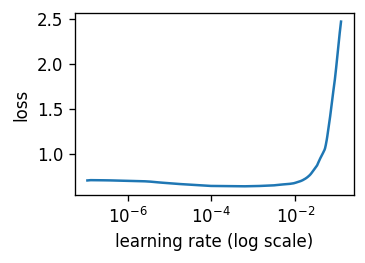

In [ ]:
learner.lr_plot()

In [ ]:
# https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6
learner.fit_onecycle(2e-5,2,class_weight=class_weight)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/2
2321/2321 [==============================] - 1056s 451ms/step - loss: 0.7780 - accuracy: 0.6659 - val_loss: 0.3289 - val_accuracy: 0.8534
Epoch 2/2
2321/2321 [==============================] - 1075s 463ms/step - loss: 0.3642 - accuracy: 0.8399 - val_loss: 0.3485 - val_accuracy: 0.8569


In [ ]:
learner.validate(class_names=t.get_classes())

              precision    recall  f1-score   support

  non-rumour       0.96      0.82      0.89       393
      rumour       0.71      0.93      0.81       187

    accuracy                           0.86       580
   macro avg       0.84      0.87      0.85       580
weighted avg       0.88      0.86      0.86       580



array([[324,  69],
       [ 14, 173]])

In [ ]:
# sst2-sentiment-bert
# batches=2, epoch=2, with @USER, #hashtagremain, class weight adjusted, weight_decay=0, learning rate=2e-5, removing almost all the symbols
# precision    recall  f1-score   support

#   non-rumour       0.93      0.88      0.90       393
#     rumour       0.77      0.86      0.82       187

#     accuracy                      0.87       580
#    macro avg      0.85      0.87      0.86       580
# weighted avg       0.88      0.87      0.88       580

# array([[346,  47],
#    [ 26, 161]])

In [ ]:
# the one we got most wrong
learner.view_top_losses(n=5, preproc=t)

In [ ]:
# print out the tweet
print(df_dev_data['text'].tolist()[25])

<CLS> I am so saddened by the death of a young man serving us and our great nation <SEP> God bless him #Ottawa #OttawaShooting <SEP>


# Prediction 

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc=preproc)

predictions = predictor.predict(df_test['text'].tolist())
prediction_series = pd.Series(predictions)
df_prediction = pd.DataFrame(prediction_series,columns=['rumor_or_not'])

df_prediction_with_id = pd.DataFrame(df_test['id_str'])
df_prediction_with_id['rumor_or_not'] = df_prediction['rumor_or_not']

df_prediction_with_id.set_index("id_str",inplace=True)
json = df_prediction_with_id['rumor_or_not'].to_json(path_or_buf="gdrive/MyDrive/NLP-project1/test-output.json")

In [ ]:
predictor.save('/content/gdrive/MyDrive/DistilBERT_best3')

In [ ]:
# https://medium.com/analytics-vidhya/re-sampling-imbalanced-training-corpus-for-sentiment-analysis-c9dc97f9eae1
# https://iq.opengenus.org/bert-cased-vs-bert-uncased/